### Title: Making Prediction of Wine Quality

### Introduction

For our group project we will be predicting the quality of different wine samples given different character traits of the wine. When wine is being processed for production and storage, it undergoes an oxidation reaction and loses some of its fruit aromas. However, this can be prevented buy adding preservatives such as sulpher dioxide. This acts as an antiseptic which prevents the prominent flavours from being lost over time and helps preserve the quality of the drink. In our study we will be asking if the quality of different wines, such as red vs white, can be predicted based on differnent factors. The factors we will be investigating include pH level, alcohol (vol%), residual sugar (g/dm^3), chlorides (g(sodium chloride)/dm3), density (g/cm^3), and citric acid (g/dm3). The quality will be determined using a 10 point scale. Current research on this topic that insipred this study comes from the article "Modeling wine preferences by data mining from physicochemical properties". The following study can be found here: https://www.sciencedirect.com/science/article/pii/S0167923609001377?via=ihub The dataset we will be using is https://www.kaggle.com/yasserh/wine-quality-dataset. The dataset has been made tidy for better comprehension and is included below.


### Method and Results

We will be conducting our data analysis by tidying a dataset, and creating visualizations to predict the quality of wine using factors such as the total.sulfur.dioxide, pH, alcohol, residual.sugar, chlorides, density, and citric.acid. While some variables have a linear relationship with quality, some not so much. But, they can be used to predict the quality after we train our model with the training data. Some future questions this could lead to include the questioning which features that together create a prefered taste and how preservatives influcence the quality of of wine with time. However, there are variables such as Chlorides and residual sugar which dont have much difference in the mean, hence would eventially have to be swapped with other variables. The plots related to all variables vs quality show how each of them differes as the quality of the wine increases. Some decrease, some increase, but through these differences we should be able to see some amazing predictions (and some even surprising ones) regarding the quality of a wine. We first planned on doing a scatter plot and a box plot, but since quality is distinct, we did a crossover and decided to overlay scatter plot over each individual box plot for each quality. This is because we could recognize the distribution between quality and the variables in y axis. We then scaled all the data and centered it so the uneveness in the data is minimized and we could properly analyze the centralized data. However, even after being scaled there doesnt seem to be much difference btween actual plot and scaled plot. 

In [3]:
# Loading package
library(tidyverse)
library(repr)
library(tidymodels)
library(GGally)
library(cowplot)

In [6]:
# Import dataset
url <- "https://raw.githubusercontent.com/SurajDatta/DSCI100_group_project/main/data/WineQT.csv"
wine_data <- read_csv(url)
colnames(wine_data) <- make.names(colnames(wine_data))

wine_data_clean <- wine_data %>%
     select(total.sulfur.dioxide, pH, alcohol, quality, residual.sugar, chlorides, density, citric.acid) %>%
     mutate(quality = as_factor(quality))
head(wine_data_clean)
nrow(wine_data_clean)

Parsed with column specification:
cols(
  `fixed acidity` = col_double(),
  `volatile acidity` = col_double(),
  `citric acid` = col_double(),
  `residual sugar` = col_double(),
  chlorides = col_double(),
  `free sulfur dioxide` = col_double(),
  `total sulfur dioxide` = col_double(),
  density = col_double(),
  pH = col_double(),
  sulphates = col_double(),
  alcohol = col_double(),
  quality = col_double(),
  Id = col_double()
)



total.sulfur.dioxide,pH,alcohol,quality,residual.sugar,chlorides,density,citric.acid
<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>
34,3.51,9.4,5,1.9,0.076,0.9978,0.00
67,3.20,9.8,5,2.6,0.098,0.9968,0.00
54,3.26,9.8,5,2.3,0.092,0.9970,0.04
60,3.16,9.8,6,1.9,0.075,0.9980,0.56
34,3.51,9.4,5,1.9,0.076,0.9978,0.00
40,3.51,9.4,5,1.8,0.075,0.9978,0.00


[1] 1143

|Variable             |Explanation                                                                       |
|---------------------|----------------------------------------------------------------------------------|
|total.sulfur.dioxide |The total amount of sulfur dioxide in wine.                                       |
|pH                   |Measure of how acidic/basic wine is.                                              | 
|alcohol              |The alchohol amount in wine.                                                      |
|quality              |The quality of wine.                                                              |
|residual.sugar       |The residual sugar in the wine after the sugar fermentation carried out by yeasts.|
|chlorides            |The chlorides amount in wine.                                                     |
|density              |The density of wine.                                                              |      
|citric.acid          |The amount of citric acid in wine.                                                |


**Table 1: List of Potential Predicors.**

This table lists the variables used to assess the quality of the wine as well as a discription for each. Each of these variables have some relationship with the qualit of wine and have potential to predict the bets wine on a given scale.

In [7]:
# data split
wine_split <- initial_split(wine_data_clean, prop = 0.75, strata = quality)
wine_train <- training(wine_split)
wine_test <- testing(wine_split)

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



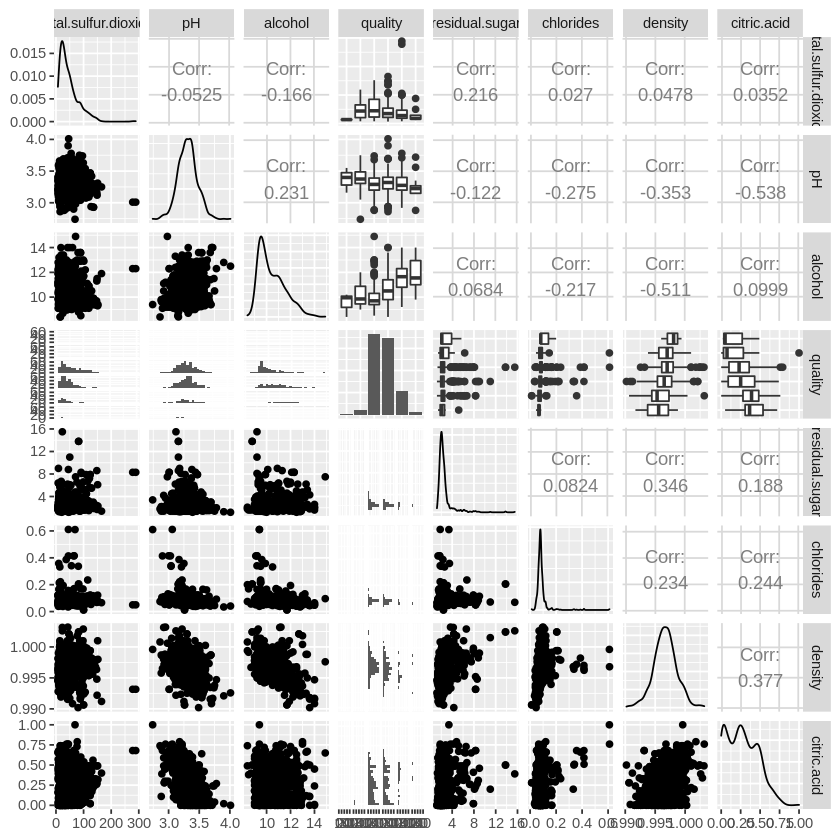

In [8]:
wine_ggpairs <- wine_train %>%
   ggpairs
wine_ggpairs

**GGpair plot**

caption: The ggpair plots of seven different data and quality shows that the *residue sugar* and *chlorides* have slightly lower corelation with quality, indicating these two variables are not suitable to be predictors.

#### The first KNN classification model is for single predictors with the predicted quality. 
We will use for_loop on each predictor to simplify the steps. 
The results will show in the table with 3 columns: **predictor**, **best k value**, and **accuracy**.
Based on accuarcy of each single predictor, we will select the best 4 predictors for further examination of combined predictors.

In [9]:
set.seed(999)

wine_subset <- wine_train %>%
  select(total.sulfur.dioxide, pH, alcohol, quality, residual.sugar, chlorides, density, citric.acid)

names <- colnames(wine_subset %>% select(-quality))

#wine_subset

# create an empty tibble to store the results
accuracies <- tibble(size = integer(), 
                     model_string = character(), 
                     accuracy = numeric())

wine_recipe <- recipe(quality ~. , data = wine_train) %>%
step_scale(all_predictors()) %>%
step_center(all_predictors())


# create a model specification
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
     set_engine("kknn") %>%
     set_mode("classification")

# create a 5-fold cross-validation object
wine_vfold <- vfold_cv(wine_subset, v = 5, strata = quality)

# store the total number of predictors
n_total <- length(names)

# stores selected predictors
selected <- c()

# for every size from 1 to the total number of predictors
for (i in 1:n_total) {
    # for every predictor still not added yet
    accs <- list()
    models <- list()
    for (j in 1:length(names)) {
        # create a model string for this combination of predictors
        preds_new <- c(selected, names[[j]])
        model_string <- paste("quality", "~", paste(preds_new, collapse="+"))

        # create a recipe from the model string
        cancer_recipe <- recipe(as.formula(model_string), 
                                data = wine_subset) %>%
                          step_scale(all_predictors()) %>%
                          step_center(all_predictors())

        # tune the KNN classifier with these predictors, 
        # and collect the accuracy for the best K
        
        #gridvals = tibble(neighbors = seq(1, 20))
        
        acc <- workflow() %>%
          add_recipe(wine_recipe) %>%
          add_model(knn_spec) %>%
          tune_grid(resamples = wine_vfold, grid = 10) %>%
          collect_metrics() %>%
          filter(.metric == "accuracy") %>%
          summarize(mx = max(mean))
        acc <- acc$mx %>% unlist()

        # add this result to the dataframe
        accs[[j]] <- acc
        models[[j]] <- model_string
    }
    jstar <- which.max(unlist(accs))
    accuracies <- accuracies %>% 
      add_row(size = i, 
              model_string = models[[jstar]], 
              accuracy = accs[[jstar]])
    selected <- c(selected, names[[jstar]])
    names <- names[-jstar]
}

accuracies

! Fold1: internal: No observations were detected in `truth` for level(s): '3'
Com...

! Fold2: internal: No observations were detected in `truth` for level(s): '8'
Com...

! Fold4: internal: No observations were detected in `truth` for level(s): '3'
Com...

! Fold5: internal: No observations were detected in `truth` for level(s): '3'
Com...

! Fold1: internal: No observations were detected in `truth` for level(s): '3'
Com...

! Fold2: internal: No observations were detected in `truth` for level(s): '8'
Com...

! Fold4: internal: No observations were detected in `truth` for level(s): '3'
Com...

! Fold5: internal: No observations were detected in `truth` for level(s): '3'
Com...

! Fold1: internal: No observations were detected in `truth` for level(s): '3'
Com...

! Fold2: internal: No observations were detected in `truth` for level(s): '8'
Com...

! Fold4: internal: No observations were detected in `truth` for level(s): '3'
Com...

! Fold5: internal: No observations were detected in `t

size,model_string,accuracy
<int>,<chr>,<dbl>
1,quality ~ total.sulfur.dioxide,0.5489965
2,quality ~ total.sulfur.dioxide+alcohol,0.5489965
3,quality ~ total.sulfur.dioxide+alcohol+residual.sugar,0.5489965
4,quality ~ total.sulfur.dioxide+alcohol+residual.sugar+pH,0.5489965
5,quality ~ total.sulfur.dioxide+alcohol+residual.sugar+pH+chlorides,0.5489965
6,quality ~ total.sulfur.dioxide+alcohol+residual.sugar+pH+chlorides+density,0.5489965
7,quality ~ total.sulfur.dioxide+alcohol+residual.sugar+pH+chlorides+density+citric.acid,0.5489965


In [ ]:
set.seed(999)

# Create list of all preditors
predictors <- c("total.sulfur.dioxide", "pH", "alcohol", "density", "citric.acid")

# Set results dataframe containing rows of single preditors, the best k, and the accuracy.
results <- tibble()
results <- mutate(results, predictor = "", best_k = 0, accuracy = 0)

for (pred in predictors) {
    
    print(pred)
    
    # Select single predictor for the recipe 
    train_data <- wine_train %>%
       select(quality, all_of(pred))
    
    train_test <- wine_test %>%
       select(quality, all_of(pred))
    
    
    wine_recipe <- recipe(quality ~. , data = wine_train) %>%
      step_scale(all_predictors()) %>%
      step_center(all_predictors())

    knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
       set_engine("kknn") %>%
       set_mode("classification")

     wine_vfold <- vfold_cv(wine_train, v = 5, strata = quality)

    gridvals = tibble(neighbors = seq(1, 20))
    
     knn_results <- workflow() %>%
       add_recipe(wine_recipe) %>%
       add_model(knn_tune) %>%
       tune_grid(resamples = wine_vfold, grid = gridvals) %>%
       collect_metrics()


      accuracy <- knn_results %>% 
         filter(.metric == "accuracy") %>%
         arrange(desc(mean)) %>%
         slice(1) %>%
         pull(mean)
      accuracy

      best_k <- knn_results %>% 
         filter(.metric == "accuracy") %>%
         arrange(desc(mean)) %>%
         slice(1) %>%
         pull(neighbors)
      best_k
    
      results <- results %>%
         add_row(predictor = pred, best_k = best_k, accuracy = accuracy)
}

In [25]:
results <- results %>%
    arrange(desc(accuracy))

best_pred <- results %>%
  slice(1)

results
best_pred

predictor,best_k,accuracy
<chr>,<dbl>,<dbl>
alcohol,16,0.5775885
pH,20,0.5763457
density,18,0.5738760
citric.acid,14,0.5726541
total.sulfur.dioxide,1,0.5703875


predictor,best_k,accuracy
<chr>,<dbl>,<dbl>
alcohol,16,0.5775885


#### Table 2: K Predictors and Their Accuracy

By performing a knn classification we are able to determine the best number of neighbors that should be used to result in the most accurate prediction. We begin by setting a seed to ensure our work is reproducible. We then randomly split the data into a training and testing set. This allowed us to work with the data set without being biased and compare our results with the real data that was not manipulated. The data was then processed and tuned before undergoing a cross validation. This will give us lower standard data. The data is finally fit and the accuracy is evaluated to give the best number of neighbors.


#### The second knn classification model is for combined predictors with the predicted quality. 
We will use for_loop on each combined predictors to simplify the steps. 
The results in the table with 3 columns: multiple predictors, best k value for multiple predictors, and accuracy for multiple predictors.

In [30]:
set.seed(999)
# List of formulas that will be used to generate recipes iteratively
formulas <- c(
"quality ~ density + alcohol + pH + citric.aicd",
"quality ~ density + alcohol + pH",
"quality ~ density + alcohol",
"quality ~ density + pH",
"quality ~ pH + alcohol",
"quality ~ citric.acid + chlorides + residual.sugar + density + pH + total.sulfur.dioxide + alcohol")

# Setup results data frame with have rows of each predictor and resulting accuracy

results_mul <- tibble()
results_mul <- mutate(results_mul, predictor_mul = "", best_k_mul = 0, accuracy_mul = 0)

for (f in formulas) {
    
    print(f)
    
    # Convert string formula to formula object
    wine_recipe_mul <- recipe(quality ~. , data = wine_train) %>%
      step_scale(all_predictors()) %>%
      step_center(all_predictors())

    knn_spec_mul <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
       set_engine("kknn") %>%
       set_mode("classification")

    wine_vfold_mul <- vfold_cv(wine_train, v = 5, strata = quality)

    gridvals_mul = tibble(neighbors = seq(1, 20))
    
    knn_results_mul <- workflow() %>%
       add_recipe(wine_recipe_mul) %>%
       add_model(knn_spec_mul) %>%
       tune_grid(resamples = wine_vfold_mul, grid = gridvals_mul) %>%
       collect_metrics() %>% 
         filter(.metric == "accuracy") %>%
         arrange(desc(mean)) %>%
         slice(1) 

    accuracy_mul <- knn_results_mul %>%
         pull(mean) 
    accuracy_mul

    best_k_mul <- knn_results_mul %>%
         pull(neighbors)
    best_k_mul
    
    results_mul <- results_mul %>%
         add_row(predictor_mul = f, best_k_mul = best_k_mul, accuracy_mul = accuracy_mul)
}

[1] "quality ~ density + alcohol + pH + citric.aicd"


! Fold1: internal: No observations were detected in `truth` for level(s): '3'
Com...

! Fold3: internal: No observations were detected in `truth` for level(s): '3'
Com...



[1] "quality ~ density + alcohol + pH"


! Fold1: internal: No observations were detected in `truth` for level(s): '3'
Com...

! Fold2: internal: No observations were detected in `truth` for level(s): '3'
Com...

! Fold4: internal: No observations were detected in `truth` for level(s): '8'
Com...

! Fold5: internal: No observations were detected in `truth` for level(s): '8'
Com...



[1] "quality ~ density + alcohol"


! Fold2: internal: No observations were detected in `truth` for level(s): '3'
Com...

! Fold3: internal: No observations were detected in `truth` for level(s): '8'
Com...

! Fold4: internal: No observations were detected in `truth` for level(s): '3'
Com...



[1] "quality ~ density + pH"
[1] "quality ~ pH + alcohol"


! Fold3: internal: No observations were detected in `truth` for level(s): '3'
Com...

! Fold4: internal: No observations were detected in `truth` for level(s): '8'
Com...



[1] "quality ~ citric.acid + chlorides + residual.sugar + density + pH + total.sulfur.dioxide + alcohol"


In [32]:
results_mul <- results_mul %>%
    arrange(desc(accuracy_mul))
results_mul
best_pred_mul <- results_mul %>%
  slice(1)
best_pred_mul

predictor_mul,best_k_mul,accuracy_mul
<chr>,<dbl>,<dbl>
quality ~ citric.acid + chlorides + residual.sugar + density + pH + total.sulfur.dioxide + alcohol,17,0.5808889
quality ~ density + alcohol,16,0.5775885
quality ~ density + alcohol + pH,20,0.5763457
quality ~ density + pH,18,0.5738760
quality ~ pH + alcohol,14,0.5726541
quality ~ density + alcohol + pH + citric.aicd,1,0.5703875


predictor_mul,best_k_mul,accuracy_mul
<chr>,<dbl>,<dbl>
quality ~ citric.acid + chlorides + residual.sugar + density + pH + total.sulfur.dioxide + alcohol,17,0.5808889


#### Table of accuracies of combined predictors

In [20]:
set.seed(999)

wine_recipe <- recipe(quality ~ density, data = wine_train) %>%
      step_scale(all_predictors()) %>%
      step_center(all_predictors())

knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
       set_engine("kknn") %>%
       set_mode("classification")

wine_vfold <- vfold_cv(wine_train, v = 5, strata = quality)

gridvals = tibble(neighbors = seq(1, 20))
    
knn_results <- workflow() %>%
       add_recipe(wine_recipe) %>%
       add_model(knn_tune) %>%
       tune_grid(resamples = wine_vfold, grid = gridvals) %>%
       collect_metrics()
accuracy <- knn_results %>% 
        filter(.metric == "accuracy") %>%
        arrange(desc(mean))
accuracy


! Fold1: internal: No observations were detected in `truth` for level(s): '3'
Com...

! Fold3: internal: No observations were detected in `truth` for level(s): '3'
Com...



neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
14,accuracy,multiclass,0.4632667,5,0.01351850,Model14
5,accuracy,multiclass,0.4631994,5,0.02548744,Model05
10,accuracy,multiclass,0.4620767,5,0.01842357,Model10
6,accuracy,multiclass,0.4597244,5,0.01931090,Model06
13,accuracy,multiclass,0.4597107,5,0.02045576,Model13
15,accuracy,multiclass,0.4562424,5,0.01677061,Model15
12,accuracy,multiclass,0.4562153,5,0.02165534,Model12
8,accuracy,multiclass,0.4551270,5,0.01808120,Model08
4,accuracy,multiclass,0.4550596,5,0.02319358,Model04


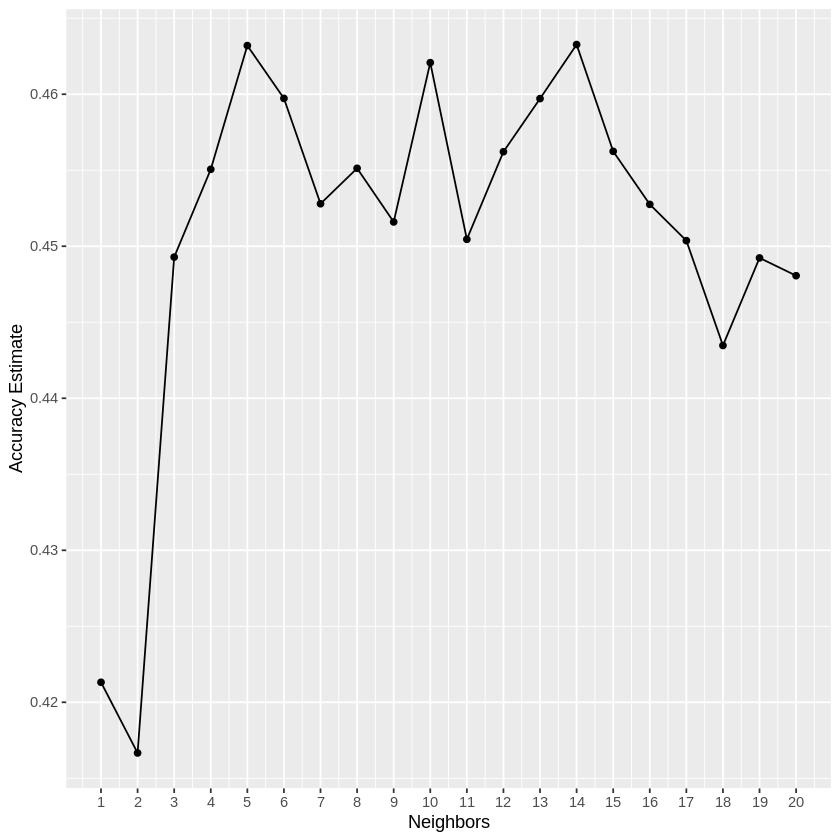

In [21]:
accuracy_vs_k <- ggplot(accuracy, aes(x = neighbors, y = mean))+
       geom_point() +
       geom_line() +
       labs(x = "Neighbors", y = "Accuracy Estimate") +
    scale_x_continuous(breaks = seq(0, 20, by = 1))
accuracy_vs_k

In [ ]:
wine_recipe_mul <- recipe(quality ~  citric.acid + chlorides + residual.sugar + density + pH + total.sulfur.dioxide + alcohol , data = wine_train) %>%
      step_scale(all_predictors()) %>%
      step_center(all_predictors())

    knn_spec_mul <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
       set_engine("kknn") %>%
       set_mode("classification")

    wine_vfold_mul <- vfold_cv(wine_train, v = 5, strata = quality)

    gridvals_mul = tibble(neighbors = seq(1, 20))
    
    knn_results_mul <- workflow() %>%
       add_recipe(wine_recipe_mul) %>%
       add_model(knn_spec_mul) %>%
       tune_grid(resamples = wine_vfold_mul, grid = gridvals_mul) %>%
       collect_metrics() 

 accuracy_mul <- knn_results_mul %>%
    filter(.metric == "accuracy") %>%
         arrange(desc(mean))
        

! Fold2: internal: No observations were detected in `truth` for level(s): '3'
Com...



In [35]:
accuracy_mul_vs_k <- ggplot(accuracy_mul, aes(x = neighbors, y = mean))+
       geom_point() +
       geom_line() +
       labs(x = "Neighbors", y = "Accuracy Estimate") +
    scale_x_continuous(breaks = seq(0, 20, by = 1))
accuracy_mul_vs_k

ERROR: Error: `data` must be a data frame, or other object coercible by `fortify()`, not a numeric vector


### Discussion



### References

- Cortez, P., Cerdeira, A., Almeida, F., Matos, T., & Reis, J. (2009). Modeling wine preferences by data mining from physicochemical properties. Decision Support Systems, 47(4), 547–553. https://doi.org/10.1016/j.dss.2009.05.016

- Wine Quality Dataset. (2022, January 15). Kaggle. https://www.kaggle.com/datasets/yasserh/wine-quality-dataset